<a href="https://colab.research.google.com/github/bjelikj/DT2119/blob/master/Labs/Lab3/Lab3_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [23]:
"""
Necessary files:
- lab3_proto.py
- lab3_tools.py
- lab1_proto.py
- lab1_tools.py
- prondict.py

If not uploaded to Google Drive:
- lab2_models_all.npz
- lab3_example.npz
"""

if IN_COLAB:
    !ls
    !rm ./*.py
    !rm -r ./__pycache__/
    # !rm lab1_proto.py
    # !rm lab1_tools.py
    # !rm lab2_proto.py
    # !rm lab2_tools.py
    # !rm lab3_proto.py
    # !rm lab3_tools.py
    # !rm lab3_example.npz
    # !rm lab2_models_all.npz

from google.colab import files
files.upload()

drive	       lab1_tools.py  lab2_tools.py  lab3_tools.py  __pycache__
lab1_proto.py  lab2_proto.py  lab3_proto.py  prondict.py    sample_data


Saving lab1_proto.py to lab1_proto.py
Saving lab1_tools.py to lab1_tools.py
Saving lab2_proto.py to lab2_proto.py
Saving lab2_tools.py to lab2_tools.py
Saving lab3_proto.py to lab3_proto.py
Saving lab3_tools.py to lab3_tools.py
Saving prondict.py to prondict.py


{'lab1_proto.py': b'# DT2119, Lab 1 Feature Extraction\r\nimport numpy as np\r\nimport matplotlib.pyplot as plt\r\nimport scipy.signal as ssi\r\nfrom scipy import fftpack\r\nfrom lab1_tools import trfbank\r\nfrom scipy.fftpack.realtransforms import dct\r\nfrom lab1_tools import *\r\nfrom scipy.spatial.distance import euclidean\r\nfrom scipy.spatial.distance import cdist\r\n\r\n# Function given by the exercise ----------------------------------\r\n\r\ndef mspec(samples, winlen=400, winshift=200, preempcoeff=0.97, nfft=512, samplingrate=20000):\r\n    """Computes Mel Filterbank features.\r\n\r\n    Args:\r\n        samples: array of speech samples with shape (N,)\r\n        winlen: lenght of the analysis window\r\n        winshift: number of samples to shift the analysis window at every time step\r\n        preempcoeff: pre-emphasis coefficient\r\n        nfft: length of the Fast Fourier Transform (power of 2, >= winlen)\r\n        samplingrate: sampling rate of the original signal\r\n\r

In [0]:
import numpy as np
import tensorflow as tf
import os
from importlib import reload

from lab1_proto import *
from lab2_proto import *
import lab3_proto
lab3_proto = reload(lab3_proto)
from lab3_proto import *
from lab1_tools import *
from lab2_tools import *
from lab3_tools import *
from prondict import prondict

## Check examples


In [25]:
example = np.load('/content/drive/My Drive/Lab3/lab3_example.npz', allow_pickle=True)['example'].item()
# print(example)
print(example['utteranceHMM'].keys())

dict_keys(['startprob', 'transmat', 'means', 'covars'])


# 4.1 Target Class Definition

In [26]:
phoneHMMs = np.load('/content/drive/My Drive/Lab3/lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()
phones = sorted(phoneHMMs.keys())
nstates = {phone: phoneHMMs[phone]['means'].shape[0] for phone in phones}
stateList = [ph + '_' + str(id) for ph in phones for id in range(nstates[ph])]
print(stateList)

['ah_0', 'ah_1', 'ah_2', 'ao_0', 'ao_1', 'ao_2', 'ay_0', 'ay_1', 'ay_2', 'eh_0', 'eh_1', 'eh_2', 'ey_0', 'ey_1', 'ey_2', 'f_0', 'f_1', 'f_2', 'ih_0', 'ih_1', 'ih_2', 'iy_0', 'iy_1', 'iy_2', 'k_0', 'k_1', 'k_2', 'n_0', 'n_1', 'n_2', 'ow_0', 'ow_1', 'ow_2', 'r_0', 'r_1', 'r_2', 's_0', 's_1', 's_2', 'sil_0', 'sil_1', 'sil_2', 'sp_0', 't_0', 't_1', 't_2', 'th_0', 'th_1', 'th_2', 'uw_0', 'uw_1', 'uw_2', 'v_0', 'v_1', 'v_2', 'w_0', 'w_1', 'w_2', 'z_0', 'z_1', 'z_2']


# 4.2 Forced Alignment

In [27]:
filename = '/content/drive/My Drive/tidigits/disc_4.1.1/tidigits/train/man/nw/z43a.wav'
samples, samplingrate = loadAudio(filename)
lmfcc = mfcc(samples)
print("LMFCC Shape: ", lmfcc.shape)

wordTrans = list(path2info(filename)[2])
print("Sequence of digits: ", wordTrans)

print("Pronunciation dictionary: ", prondict)

phoneTrans = words2phones(wordTrans, prondict, addSilence=True, addShortPause=True)
print("Phone level transcription: ", phoneTrans)

utteranceHMM = concatHMMs(phoneHMMs, phoneTrans)
stateTrans = [phone + '_' + str(stateid) for phone in phoneTrans
              for stateid in range(nstates[phone])]

LMFCC Shape:  (178, 13)
Sequence of digits:  ['z', '4', '3']
Pronunciation dictionary:  {'o': ['ow'], 'z': ['z', 'iy', 'r', 'ow'], '1': ['w', 'ah', 'n'], '2': ['t', 'uw'], '3': ['th', 'r', 'iy'], '4': ['f', 'ao', 'r'], '5': ['f', 'ay', 'v'], '6': ['s', 'ih', 'k', 's'], '7': ['s', 'eh', 'v', 'ah', 'n'], '8': ['ey', 't'], '9': ['n', 'ay', 'n']}
Phone level transcription:  ['sil', 'z', 'iy', 'r', 'ow', 'sp', 'f', 'ao', 'r', 'sp', 'th', 'r', 'iy', 'sp', 'sil']


In [29]:
# Compare with examples
for i in example['utteranceHMM'].keys():
    print(utteranceHMM[i].shape)
    print(example['utteranceHMM'][i].shape)
    print(compare(utteranceHMM[i], example['utteranceHMM'][i]))

obsloglik = log_multivariate_normal_density_diag(lmfcc, utteranceHMM['means'], utteranceHMM['covars'])
viterbi_loglik, viterbi_path = viterbi(obsloglik, np.log(utteranceHMM['startprob']), np.log(utteranceHMM['transmat']))
viterbiStateTrans = [stateTrans[idx] for idx in viterbi_path.astype(np.int64)]

print('Comparing obsloglik...', compare(obsloglik, example['obsloglik']))
print('Comparing viterbiPath...', compare(viterbi_path, example['viterbiPath']))
print('Comparing viterbiStateTrans...', np.all(viterbiStateTrans == example['viterbiStateTrans']))
frames = frames2trans(viterbiStateTrans, outfilename= ''.join(path2info(filename)[2:]) + '.lab')

(40,)
(40,)
True
(40, 40)
(40, 40)
True
(39, 13)
(39, 13)
True
(39, 13)
(39, 13)
True
Comparing obsloglik... True
Comparing viterbiPath... True
Comparing viterbiStateTrans... True


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


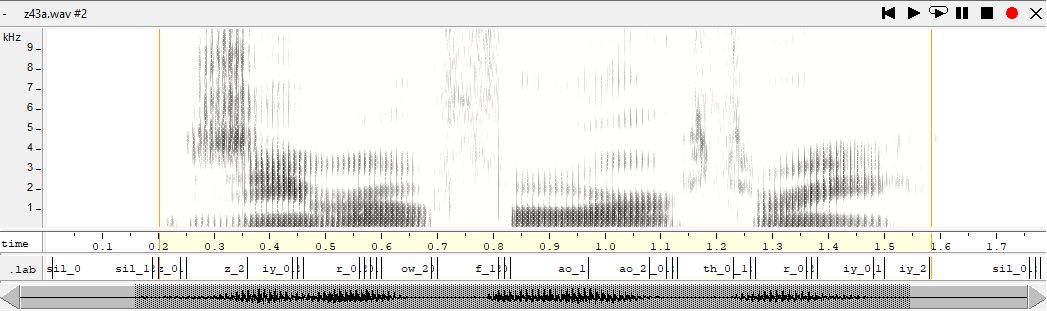

In [31]:
from IPython.display import Image
Image(filename='/content/drive/My Drive/z43a_wavesurfer.png')

# 4.3 Feature Extraction

In [0]:
def extract_features_and_targets(filename):
    """ extracts lmfcc, mspecc and targets from a *.wav sound file
    Args:
        filename: location of .wav file
    Output:
        lmfcc: liftered mfcc features
        mspec: filterbank features
        targets: indices of the target state for each feature
    """
    samples, samplingrate = loadAudio(filename)
    wordTrans = list(path2info(filename)[2])
    phoneTrans = words2phones(wordTrans, prondict)
    stateTrans = [phone + '_' + str(stateid) for phone in phoneTrans 
                  for stateid in range(nstates[phone])]
    utteranceHMM = concatHMMs(phoneHMMs, phoneTrans)

    # stateTrans = [phone + '_' + str(stateid) for phone in phoneTrans
    #           for stateid in range(nstates[phone])]

    lmfcc = mfcc(samples)
    mspecc = mspec(samples)

    obsloglik = log_multivariate_normal_density_diag(lmfcc, utteranceHMM['means'], utteranceHMM['covars'])
    viterbi_loglik, viterbi_path = viterbi(obsloglik, np.log(utteranceHMM['startprob']), np.log(utteranceHMM['transmat']), True)
    targets = [stateTrans[idx] for idx in viterbi_path.astype(np.int64)] 

    return lmfcc, mspecc, targets

In [0]:
traindata = []
for root, dirs, files in os.walk('/content/drive/My Drive/tidigits/disc_4.1.1/tidigits/train'):
  for file in files:
    if file.endswith('.wav'):
      filename = os.path.join(root, file)
      samples, samplingrate = loadAudio(filename)
      lmfcc, mspecc, targets =  extract_features_and_targets(filename)
      traindata.append({'filename': filename, 'lmfcc': lmfcc,
                        'mspec': mspec, 'targets': targets})

np.savez('/content/drive/My Drive/Lab3/traindata.npz', traindata=traindata)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


In [0]:
testdata = []
for root, dirs, files in os.walk('/content/drive/My Drive/tidigits/disc_4.2.1/tidigits/test'):
  for file in files:
    if file.endswith('.wav'):
      filename = os.path.join(root, file)
      samples, samplingrate = loadAudio(filename)
      lmfcc, mspecc, targets =  extract_features_and_targets(filename)
      testdata.append({'filename': filename, 'lmfcc': lmfcc,
                        'mspec': mspec, 'targets': targets})

np.savez('/content/drive/My Drive/Lab3/testdata.npz', testdata=testdata)

# 4.4 Training and Validation Sets

##### Split the training data into a training set (roughly 90%) and validation set (remaining 10%). Make sure that there is a similar distribution of men and women in both sets, and that each speaker is only included in one of the two sets. The last requirement is to ensure that we do not get artificially good results on the validation set. Explain how you selected the two data sets.

In [0]:
traindata = np.load('/content/drive/My Drive/Lab3/traindata.npz', allow_pickle=True)['traindata']
testdata = np.load('/content/drive/My Drive/Lab3/testdata.npz', allow_pickle=True)['testdata']

# 4.5 Acoustic Context (Dynamic Features)

In [0]:
# For each utterance and time step, stack 7 MFCC or filterbank features symmetrically distributed
# around the current time step. That is, at time n, stack the features at times [n􀀀3; n􀀀
# 2; n􀀀1; n; n+1; n+2; n+3]). At the beginning and end of each utterance, use mirrored feature
# vectors in place of the missing vectors. For example at the beginning use feature vectors with
# indexes [3; 2; 1; 0; 1; 2; 3] for the first time step, [2; 1; 0; 1; 2; 3; 4] for the second time step, and so
# on. The “boundary effect” is usually not very important because each utterance begins and ends
# with silence.

# 4.6 Feature Standardisation